<a href="https://colab.research.google.com/github/OJB-Quantum/MuMax3-How-To/blob/main/Python%20Code_MuMax3%20Data%20Plots/Domain_Wall_Motion_on_a_Permalloy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Check GPU + driver
!nvidia-smi --query-gpu="name,driver_version,compute_cap" --format=csv

name, driver_version, compute_cap
NVIDIA L4, 550.54.15, 8.9


In [ ]:
#@title Install MuMax³ (MuMax³ 3.10 CUDA 10.1)
# Download the mumax3 binary
!wget -q https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
!tar -xvf mumax3.10_linux_cuda10.1.tar.gz
!rm mumax3.10_linux_cuda10.1.tar.gz
!rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10

# Update the PATH environment variable
import os
os.environ["PATH"] += ":/content/mumax3.10"

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


In [ ]:
# @title Imports & folders (PEP 8 / PEP 257 compliant)
from __future__ import annotations

import os
import glob
import math
import subprocess
from dataclasses import dataclass
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.dpi": 200})

BASE = "/content"
OUTDIR = os.path.join(BASE, "py_racetrack.out")
NPYDIR = os.path.join(BASE, "py_racetrack_npy")
PLOTDIR = os.path.join(BASE, "py_racetrack_plots")

for d in (NPYDIR, PLOTDIR):
    os.makedirs(d, exist_ok=True)

print("Output dir:", OUTDIR)
print("NPY dir:", NPYDIR)
print("Plots dir:", PLOTDIR)


Output dir: /content/py_racetrack.out
NPY dir: /content/py_racetrack_npy
Plots dir: /content/py_racetrack_plots


In [ ]:
# @title Knobs + write MuMax3 input (.mx3)
@dataclass(frozen=True)
class SimKnobs:
    """Control knobs for the racetrack DW example."""
    grid: Tuple[int, int, int] = (256, 64, 1)
    cell: Tuple[float, float, float] = (3e-9, 3e-9, 10e-9)
    msat: float = 860e3
    aex: float = 13e-12
    alpha: float = 0.02
    xi: float = 0.1
    pol: float = 0.56
    jx: float = -10e12
    run_time: float = 0.5e-9
    save_m_every: float = 50e-12
    save_table_every: float = 10e-12

KNOBS = SimKnobs()

mx3_path = os.path.join(BASE, "py_racetrack.mx3")
with open(mx3_path, "w") as f:
    f.write(f"""
// -------- Py racetrack DW (Permalloy), Zhang–Li STT --------
// Based on the official MuMax3 example (Py Racetrack).
// Geometry, wall-centering, and surface-charge removal per docs/examples.

setGridSize({KNOBS.grid[0]}, {KNOBS.grid[1]}, {KNOBS.grid[2]})
setCellSize({KNOBS.cell[0]}, {KNOBS.cell[1]}, {KNOBS.cell[2]})

// Material (Permalloy-like)
Msat  = {KNOBS.msat}
Aex   = {KNOBS.aex}
alpha = {KNOBS.alpha}
xi    = {KNOBS.xi}

// Two-domain initial state (wall in the middle)
m = twodomain(1,0,0,  0,1,0,  -1,0,0)

// Diamond notches repeated along x, centered in y
notches := rect(15e-9, 15e-9).RotZ(45*pi/180).Repeat(200e-9, {KNOBS.grid[1]}*{KNOBS.cell[1]}, 0).Transl(0, {KNOBS.grid[1]}*{KNOBS.cell[1]}/2, 0)
setGeom(notches.inverse())

// Remove LR surface charge to mimic infinite wire
BoundaryRegion := 0
MagLeft  :=  1
MagRight := -1
ext_rmSurfaceCharge(BoundaryRegion, MagLeft, MagRight)

// Relax, then keep m_x ~ 0 to follow the wall
relax()
ext_centerWall(0)

// Schedule outputs
autosave(m, {KNOBS.save_m_every})      // OVF frames
tableadd(ext_dwpos)                     // domain-wall position (m)
tableautosave({KNOBS.save_table_every})

// Drive with spin-polarized current (Zhang–Li STT)
Pol = {KNOBS.pol}
J   = vector({KNOBS.jx}, 0, 0)

// Run
Run({KNOBS.run_time})
""")

print("Wrote:", mx3_path)


Wrote: /content/py_racetrack.mx3


In [ ]:
# @title Run MuMax3 (assumes mumax3 is already installed & on PATH)
def run_mumax3(mx3_file: str) -> None:
    """Run MuMax3 on the given script."""
    env = os.environ.copy()
    # You can pin a GPU via: env["MUMAX3_SELECT_GPU"] = "0"
    print("Running:", mx3_file)
    result = subprocess.run(["mumax3", mx3_file], capture_output=True, text=True)
    print(result.stdout)
    if result.returncode != 0:
        print(result.stderr)
        raise RuntimeError("MuMax3 run failed.")

run_mumax3(mx3_path)
print("MuMax3 finished. Out dir should exist at:", OUTDIR)


Running: /content/py_racetrack.mx3
//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: NVIDIA L4(22692MB), CUDA Driver 12.4, cc=8.9, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: /content/py_racetrack.out/
//starting GUI at http://127.0.0.1:35367
setGridSize(256, 64, 1)
setCellSize(3e-09, 3e-09, 1e-08)
Msat = 860000.0
Aex = 1.3e-11
alpha = 0.02
xi = 0.1
m = twodomain(1, 0, 0, 0, 1, 0, -1, 0, 0)
notches := rect(15e-9, 15e-9).RotZ(45*pi/180).Repeat(200e-9, 64*3e-09, 0).Transl(0, 64*3e-09/2, 0)
setGeom(notches.inverse())
// Initializing geometry 1 %
// Initializing geometry 100 %

In [ ]:
# @title Convert OVF frames to .npy with mumax3-convert
def ovf_to_numpy(ovf_glob: str, out_dir: str) -> List[str]:
    """Convert OVF(s) to .npy using mumax3-convert -numpy."""
    os.makedirs(out_dir, exist_ok=True)
    ovfs = sorted(glob.glob(ovf_glob))
    npys = []
    for ovf in ovfs:
        cmd = ["mumax3-convert", "-numpy", "-o", out_dir, ovf]
        r = subprocess.run(cmd, capture_output=True, text=True)
        if r.returncode != 0:
            print(r.stderr)
            raise RuntimeError(f"Conversion failed for {ovf}")
        # Output file is same stem with .npy
        stem = os.path.splitext(os.path.basename(ovf))[0]
        npy = os.path.join(out_dir, f"{stem}.npy")
        npys.append(npy)
    return npys

npy_paths = ovf_to_numpy(os.path.join(OUTDIR, "m*.ovf"), NPYDIR)
print("Converted frames:", len(npy_paths))
print("First 3:", npy_paths[:3])


Converted frames: 11
First 3: ['/content/py_racetrack_npy/m000000.npy', '/content/py_racetrack_npy/m000001.npy', '/content/py_racetrack_npy/m000002.npy']


Saved: /content/py_racetrack_plots/dwpos_timeseries.csv


/tmp/ipython-input-1394135707.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


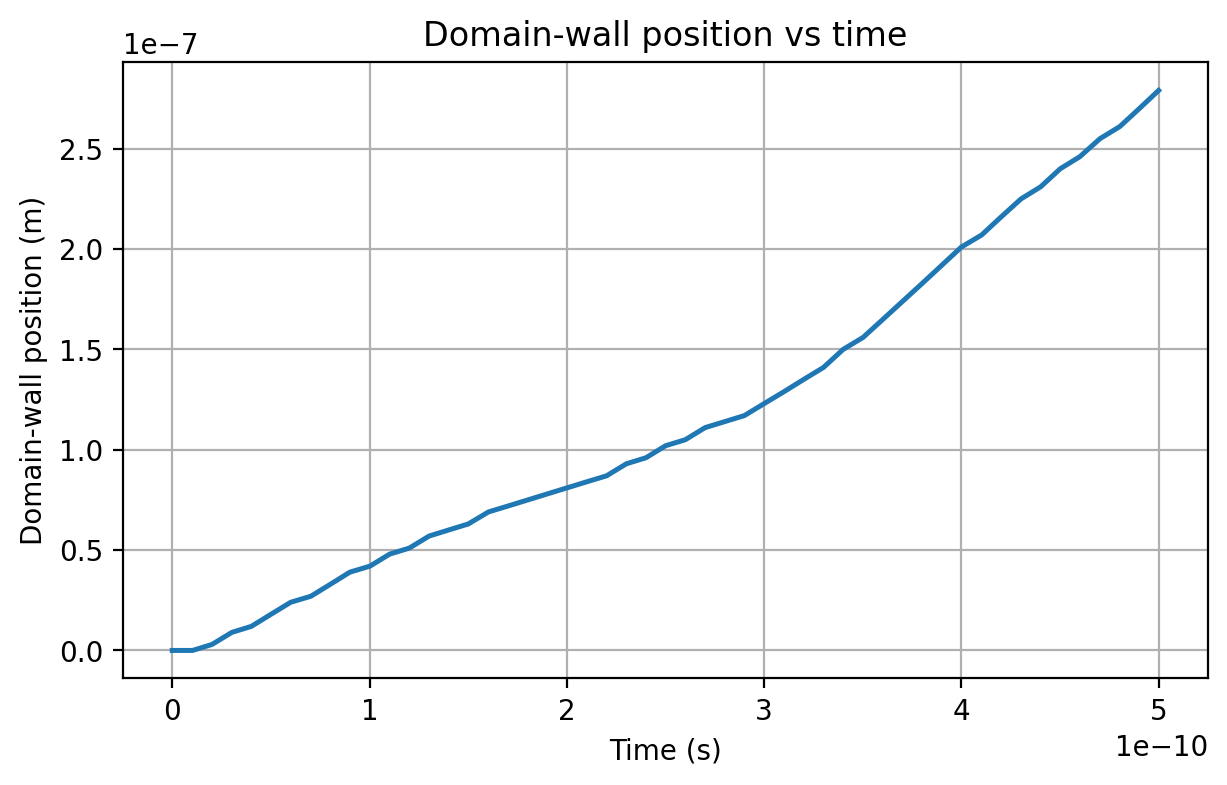

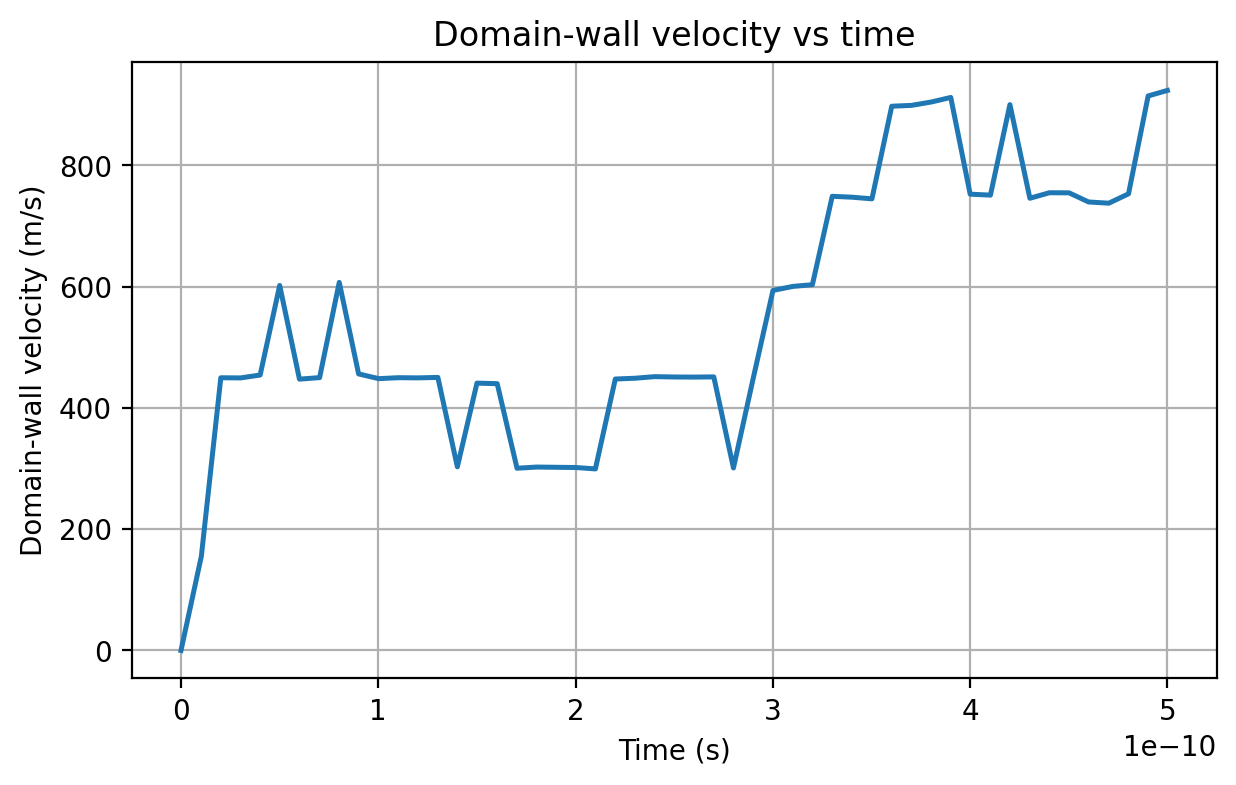

In [ ]:
# @title Plot domain-wall position & velocity from table.txt
def load_table(table_path: str) -> pd.DataFrame:
    """Load MuMax3 table.txt robustly, inferring columns if needed."""
    # Try to read while skipping comments
    df = pd.read_csv(
        table_path,
        comment="#",
        delim_whitespace=True,
        header=None,
        engine="python",
    )
    # Heuristic: time is col 0; if ext_dwpos present, it is typically the last col.
    cols = [f"col{i}" for i in range(df.shape[1])]
    df.columns = cols
    df.rename(columns={"col0": "t_s"}, inplace=True)
    # Try to find ext_dwpos by name in header lines (optional refinement)
    # Fallback: use the last column
    df["dwpos_m"] = df.iloc[:, -1]
    return df

tab = load_table(os.path.join(OUTDIR, "table.txt"))

# Compute velocity by finite difference
t = tab["t_s"].to_numpy()
x = tab["dwpos_m"].to_numpy()
v = np.gradient(x, t)  # m/s

# Save augmented CSV for completeness
tab_out = os.path.join(PLOTDIR, "dwpos_timeseries.csv")
pd.DataFrame({"t_s": t, "dwpos_m": x, "v_m_per_s": v}).to_csv(tab_out, index=False)
print("Saved:", tab_out)

# Plots
plt.figure(figsize=(7, 4))
plt.plot(t, x, lw=1.8)
plt.xlabel("Time (s)")
plt.ylabel("Domain-wall position (m)")
plt.title("Domain-wall position vs time")
plt.grid(True)
plt.savefig(os.path.join(PLOTDIR, "dw_position_vs_time.png"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(t, v, lw=1.8)
plt.xlabel("Time (s)")
plt.ylabel("Domain-wall velocity (m/s)")
plt.title("Domain-wall velocity vs time")
plt.grid(True)
plt.savefig(os.path.join(PLOTDIR, "dw_velocity_vs_time.png"), bbox_inches="tight")
plt.show()


In [ ]:
# @title Helpers: load frame, fix axes, slice components
def load_frame_npy(npy_path: str) -> np.ndarray:
    """Load a single m-frame as an array with shape (Nz, Ny, Nx, 3).

    MuMax3 numpy output is commonly (3, Nz, Ny, Nx). We standardize to (Nz, Ny, Nx, 3).
    """
    arr = np.load(npy_path)
    if arr.ndim == 4:
        # If shape is (3, Nz, Ny, Nx), move comp-axis to last
        if arr.shape[0] == 3:
            arr = np.moveaxis(arr, 0, -1)  # -> (Nz, Ny, Nx, 3)
        # If shape is (Nz, Ny, Nx, 3), already OK
        elif arr.shape[-1] == 3:
            pass
        else:
            # Fallback: try to find the component axis
            comp_axis = int(np.argmin(arr.shape))  # crude heuristic
            arr = np.moveaxis(arr, comp_axis, -1)
    else:
        raise ValueError(f"Unexpected frame shape {arr.shape}")
    return arr.astype(np.float64)

def pick_frames(paths: List[str]) -> Dict[str, str]:
    """Return first/middle/last frame paths."""
    if not paths:
        raise FileNotFoundError("No frames found.")
    idx0 = 0
    idxm = len(paths) // 2
    idx1 = len(paths) - 1
    return {"begin": paths[idx0], "middle": paths[idxm], "end": paths[idx1]}


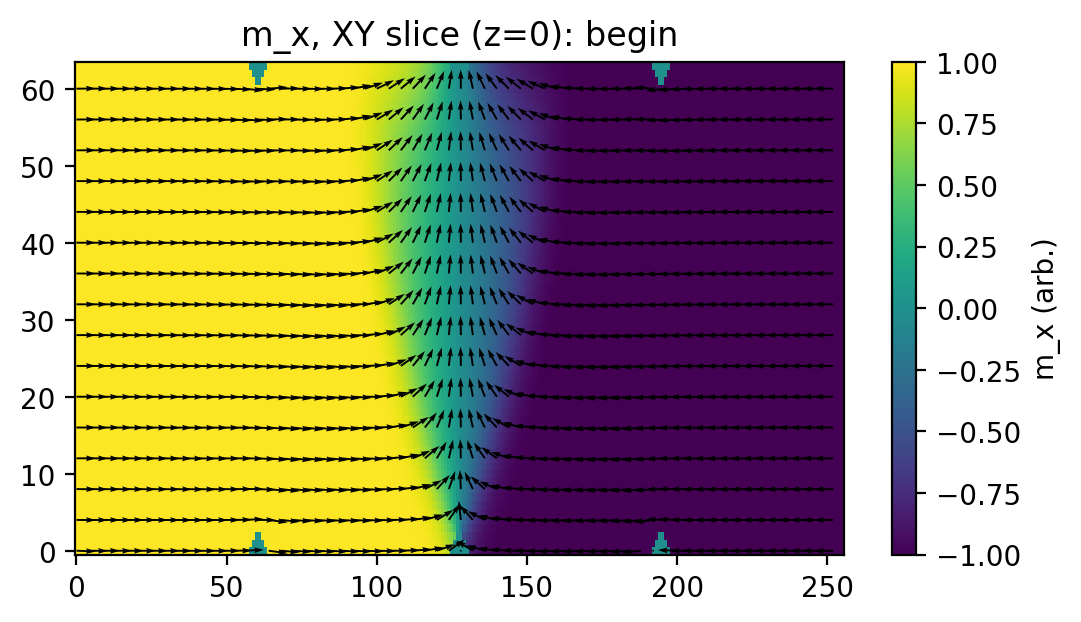

Saved: /content/py_racetrack_plots/xy_begin.png


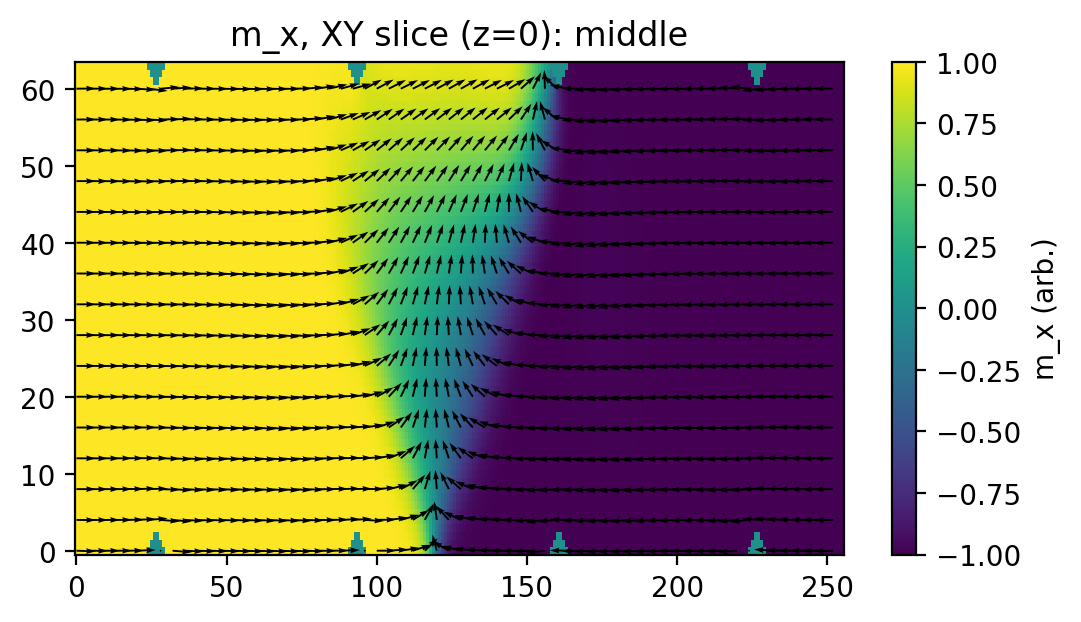

Saved: /content/py_racetrack_plots/xy_middle.png


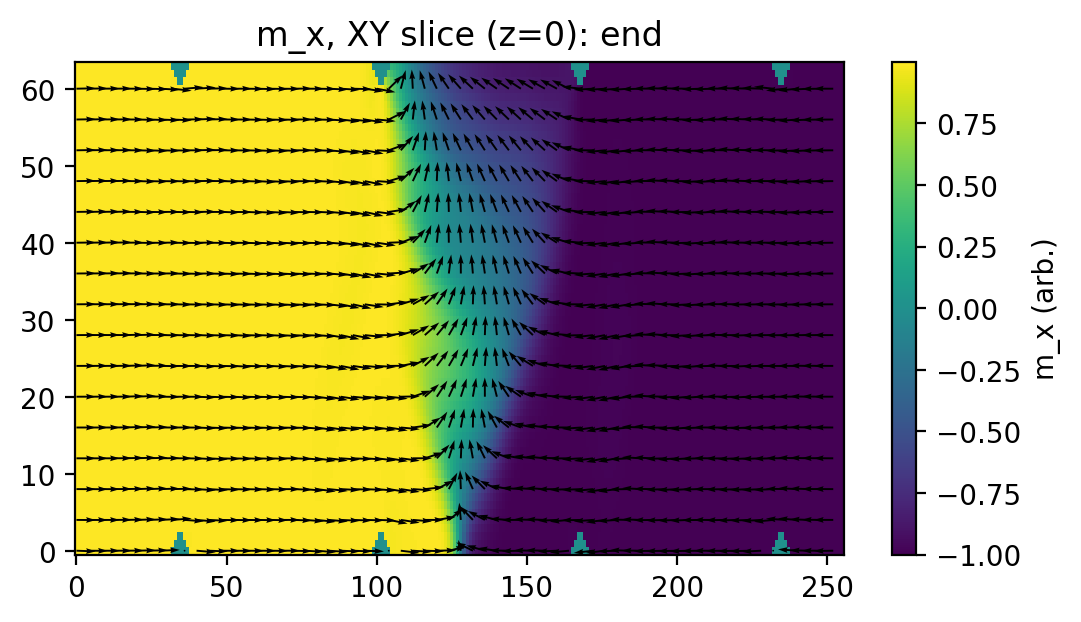

Saved: /content/py_racetrack_plots/xy_end.png


In [ ]:
# @title XY snapshots of m (begin/middle/end)
def plot_xy_snapshot(frame_path: str, tag: str, quiver_skip: int = 4) -> None:
    """Plot XY magnetization (z=0 slice): mx heatmap + (mx,my) quiver."""
    arr = load_frame_npy(frame_path)
    # Expect Nz=1 in this setup
    mx = arr[0, :, :, 0]
    my = arr[0, :, :, 1]
    # heatmap of mx
    plt.figure(figsize=(6.2, 3.2))
    plt.imshow(mx, origin="lower", aspect="auto")
    plt.colorbar(label="m_x (arb.)")
    plt.title(f"m_x, XY slice (z=0): {tag}")
    # quiver overlay (decimated)
    yy, xx = np.mgrid[0:mx.shape[0], 0:mx.shape[1]]
    plt.quiver(
        xx[::quiver_skip, ::quiver_skip],
        yy[::quiver_skip, ::quiver_skip],
        mx[::quiver_skip, ::quiver_skip],
        my[::quiver_skip, ::quiver_skip],
        scale=40,
        width=0.0025,
    )
    out_png = os.path.join(PLOTDIR, f"xy_{tag}.png")
    plt.savefig(out_png, bbox_inches="tight", dpi=200)
    plt.show()
    print("Saved:", out_png)

sel = pick_frames(npy_paths)
for tag, p in sel.items():
    plot_xy_snapshot(p, tag, quiver_skip=4)


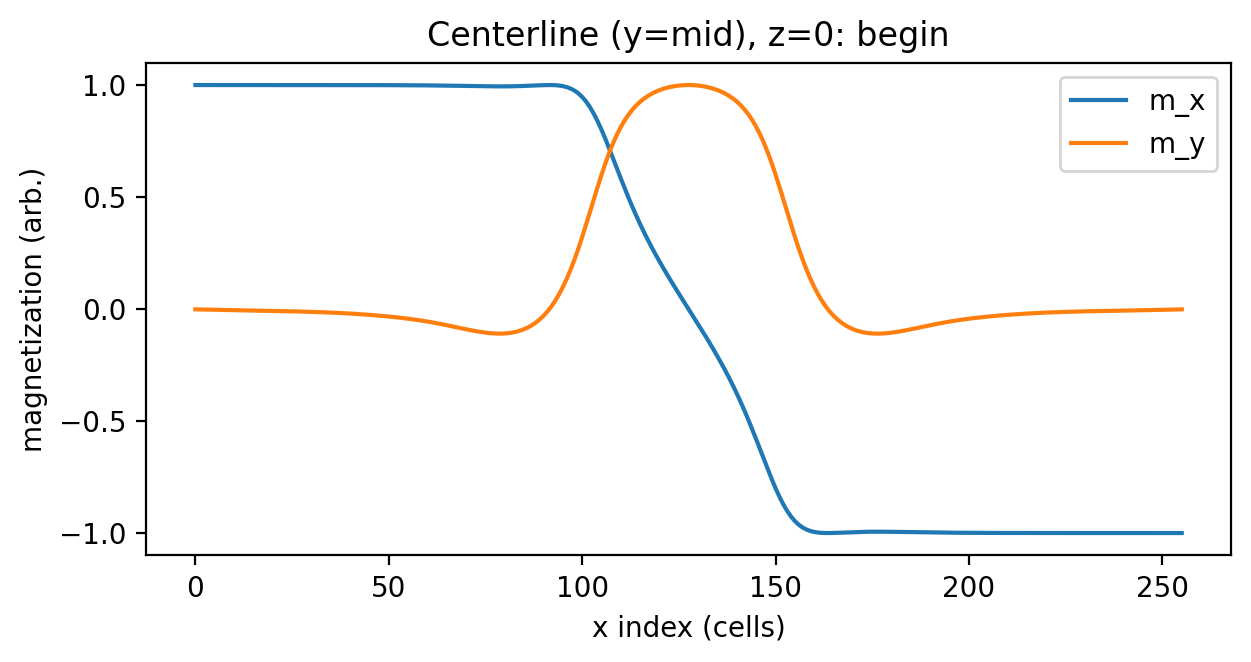

Saved: /content/py_racetrack_plots/centerline_begin.png


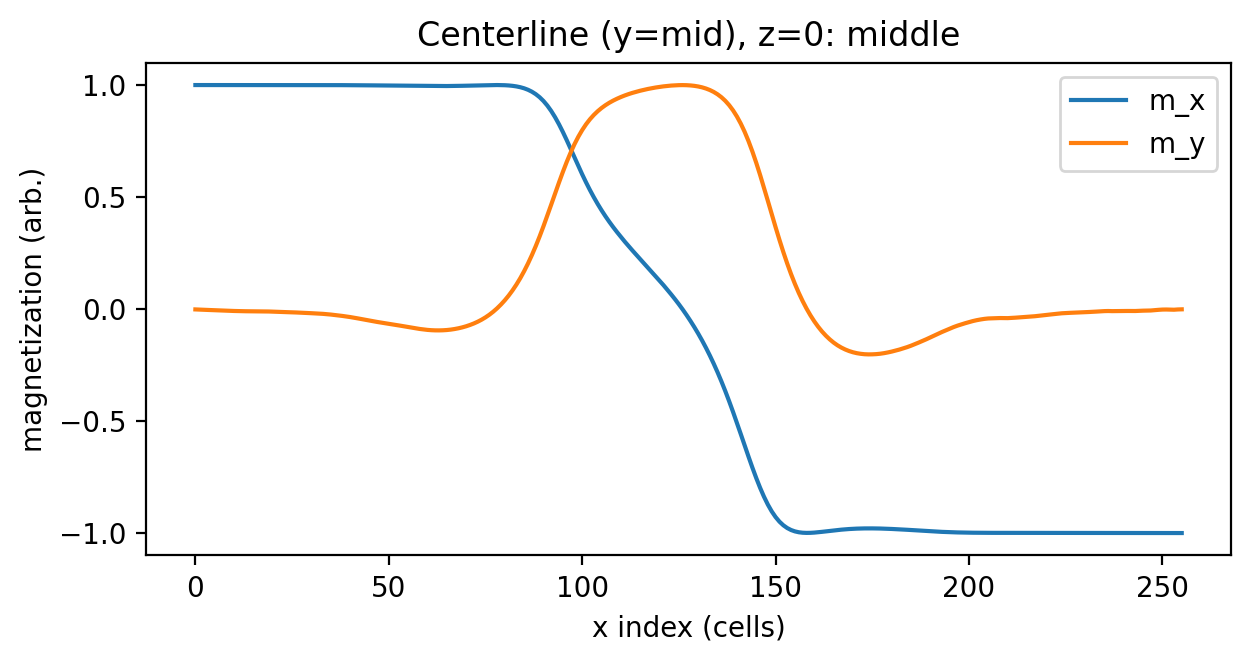

Saved: /content/py_racetrack_plots/centerline_middle.png


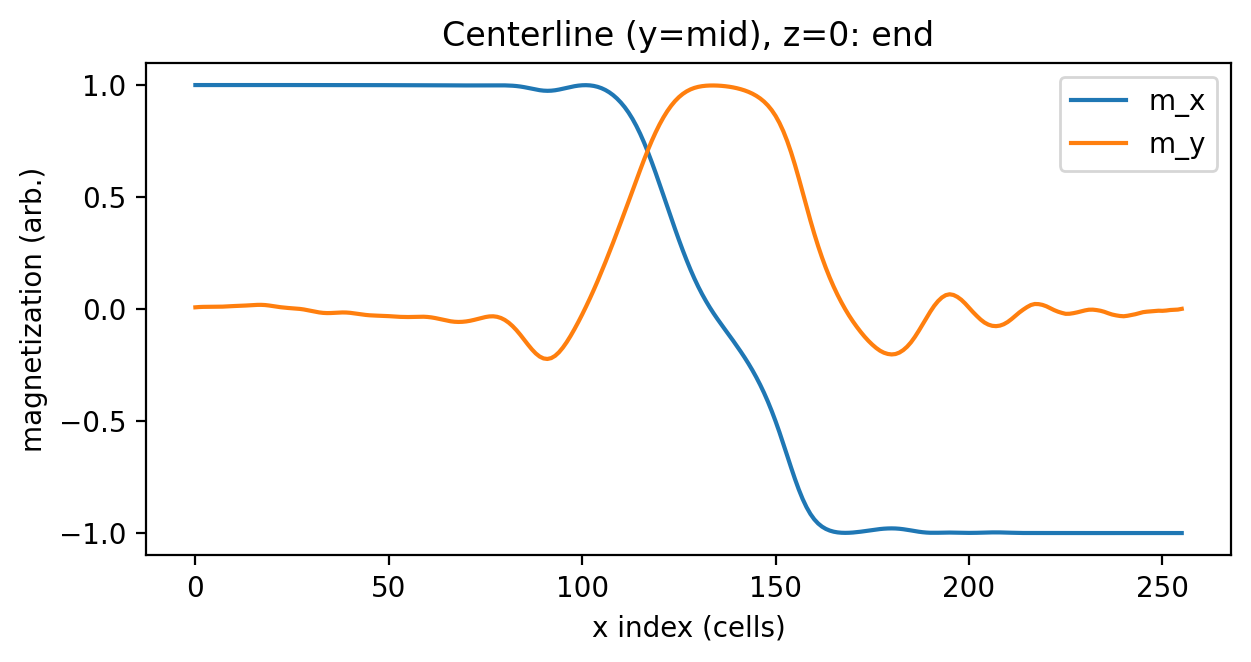

Saved: /content/py_racetrack_plots/centerline_end.png


In [ ]:
# @title Centerline cross-sections of mx,my (mid-y)
def plot_centerline(frame_path: str, tag: str) -> None:
    """Plot mx,my along x at y = Ny//2, z=0."""
    arr = load_frame_npy(frame_path)
    mx = arr[0, :, :, 0]
    my = arr[0, :, :, 1]
    y_mid = mx.shape[0] // 2
    mx_line = mx[y_mid, :]
    my_line = my[y_mid, :]

    plt.figure(figsize=(7, 3.2))
    plt.plot(mx_line, label="m_x")
    plt.plot(my_line, label="m_y")
    plt.xlabel("x index (cells)")
    plt.ylabel("magnetization (arb.)")
    plt.title(f"Centerline (y=mid), z=0: {tag}")
    plt.legend()
    out_png = os.path.join(PLOTDIR, f"centerline_{tag}.png")
    plt.savefig(out_png, bbox_inches="tight", dpi=200)
    plt.show()
    print("Saved:", out_png)

for tag, p in sel.items():
    plot_centerline(p, tag)
